# Disclaimer: Code created by Ferhat Özgur Catak, and modifications made by Oddvar Nordbø Øksendal

In [1]:
!pip install -q bitstring
!pip install -q pandas
!pip install -q seaborn
!pip install -q nistrng
!pip install -q mpl_toolkits

from operator import xor
import bitstring

import numpy as np
from randomgen import ChaCha
from numpy.random import Generator, SeedSequence, PCG64
import pandas as pd
import seaborn as sns
import scipy.io as sio

from random import SystemRandom
from scipy.special import entr
import matplotlib.pyplot as plt
import cv2 

from tqdm import tqdm
from glob import glob

from nistrng import *

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

ERROR: Could not find a version that satisfies the requirement mpl_toolkits (from versions: none)
ERROR: No matching distribution found for mpl_toolkits


4.824290057056199


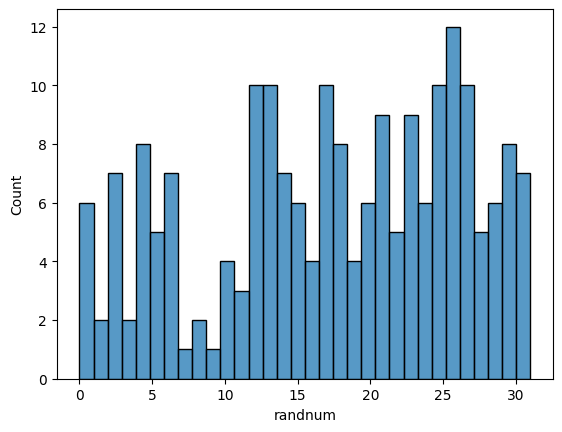

In [2]:
NUM_OF_ELEMENTS=32
SIZE = 200
randomint = np.random.randint(0,NUM_OF_ELEMENTS,SIZE)
df = pd.DataFrame({'randnum':randomint})
ax = sns.histplot(data=df, x="randnum", bins=NUM_OF_ELEMENTS)

vals = np.array([h.get_height() for h in ax.patches])

pA = vals / vals.sum()
Shannon2 = -np.nansum(pA*np.log2(pA))
print(Shannon2)

4.867371379366527 [0.005 0.025 0.03  0.02  0.04  0.02  0.03  0.02  0.02  0.025 0.045 0.04
 0.04  0.02  0.035 0.025 0.05  0.045 0.02  0.025 0.04  0.035 0.02  0.015
 0.04  0.065 0.025 0.045 0.01  0.05  0.03  0.045]


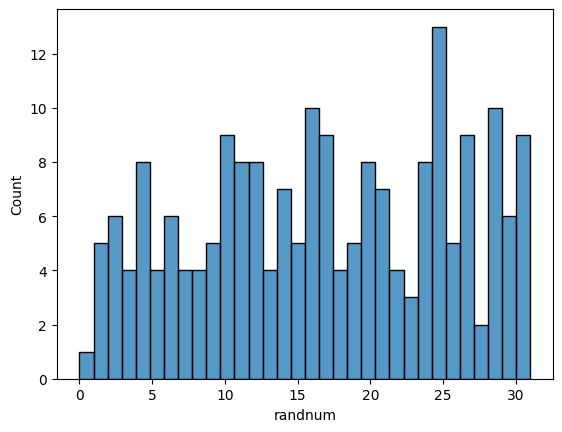

In [3]:
cryptogen = SystemRandom()
cryptogen.randrange(NUM_OF_ELEMENTS)

randomint_sec = [cryptogen.randrange(NUM_OF_ELEMENTS) for i in range(SIZE)]

df_sec = pd.DataFrame({'randnum':randomint_sec})
ax = sns.histplot(data=df_sec, x="randnum", bins=NUM_OF_ELEMENTS)

vals_sec = np.array([h.get_height() for h in ax.patches])
pA = vals_sec / vals_sec.sum()
Shannon2 = -np.nansum(pA*np.log2(pA))
print(Shannon2, pA)

In [4]:
files = glob('../GeneratedData\\NR*.png')
num_of_files = len(files)
FRAME_SIZE = 70

def get_entropy_spectrum(c, k, sel_img_idx):
    sel_img = files[sel_img_idx]
    
    img = cv2.imread(sel_img)

    if c == 0:
        c = 1
    if k == 0:
        k = 1
    
    start_x = np.random.randint(img.shape[0] - c)
    start_y = np.random.randint(img.shape[1] - k)
    
    selected_spectogram = img[start_x:start_x+c, start_y:start_y+k, :].flatten()
    
    random_bits = bitstring.BitArray(float=selected_spectogram[0], length=32)
    
    for i in range(1,selected_spectogram.shape[0]):
        tmp = bitstring.BitArray(float=selected_spectogram[i], length=32) 
        random_bits = random_bits ^ tmp # xor
        random_bits = random_bits ^ random_bits << 13
        random_bits = random_bits ^ random_bits >> 17
        random_bits = random_bits ^ random_bits << 5
    
    return random_bits.uintle, random_bits

tmp_rand,random_bits = get_entropy_spectrum(1,2,1)
print(tmp_rand, random_bits.uint, random_bits.uintbe, random_bits.uintle, random_bits.uintne)

157509177 963011337 963011337 157509177 157509177


step 1
4.893113686878812


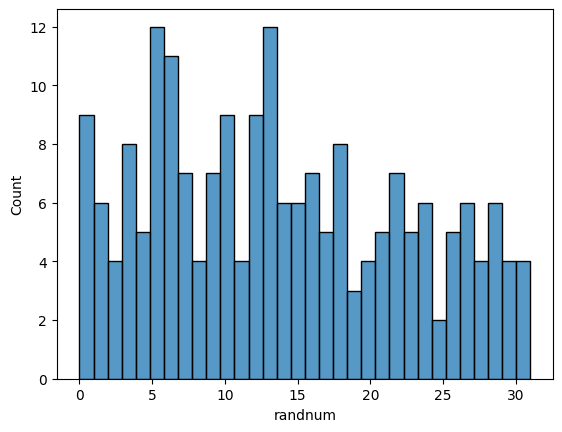

In [5]:
# Using a seed from the entropy spectrum and a CSRPNG.
randomint_sec2 = []

print('step 1')
entropy_val = get_entropy_spectrum((239),(43),64)
generator = Generator(ChaCha(SeedSequence(entropy_val)))
randomint_sec2 = generator.integers(0, NUM_OF_ELEMENTS, SIZE)
    
df_sec2 = pd.DataFrame({'randnum':randomint_sec2})
ax = sns.histplot(data=df_sec2, x="randnum", bins=NUM_OF_ELEMENTS)

vals_sec2 = np.array([h.get_height() for h in ax.patches])
pA = vals_sec2 / vals_sec2.sum()
Shannon2 = -np.nansum(pA*np.log2(pA))
print(Shannon2)

step 1
4.849293737593613


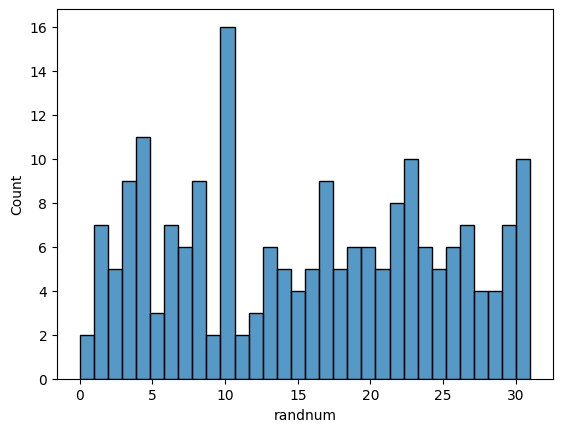

In [6]:
# Using a seed from the entropy spectrum and a PRNG.
randomint_sec2 = []

print('step 1')
entropy_val = get_entropy_spectrum(0,0,100)
generator = Generator(PCG64(SeedSequence(entropy_val)))
randomint_sec2 = generator.integers(0, NUM_OF_ELEMENTS, SIZE)
    
df_sec2 = pd.DataFrame({'randnum':randomint_sec2})
ax = sns.histplot(data=df_sec2, x="randnum", bins=NUM_OF_ELEMENTS)

vals_sec2 = np.array([h.get_height() for h in ax.patches])
pA = vals_sec2 / vals_sec2.sum()
Shannon2 = -np.nansum(pA*np.log2(pA))
print(Shannon2)

# Analysis

(369, 169, 4)
90 91


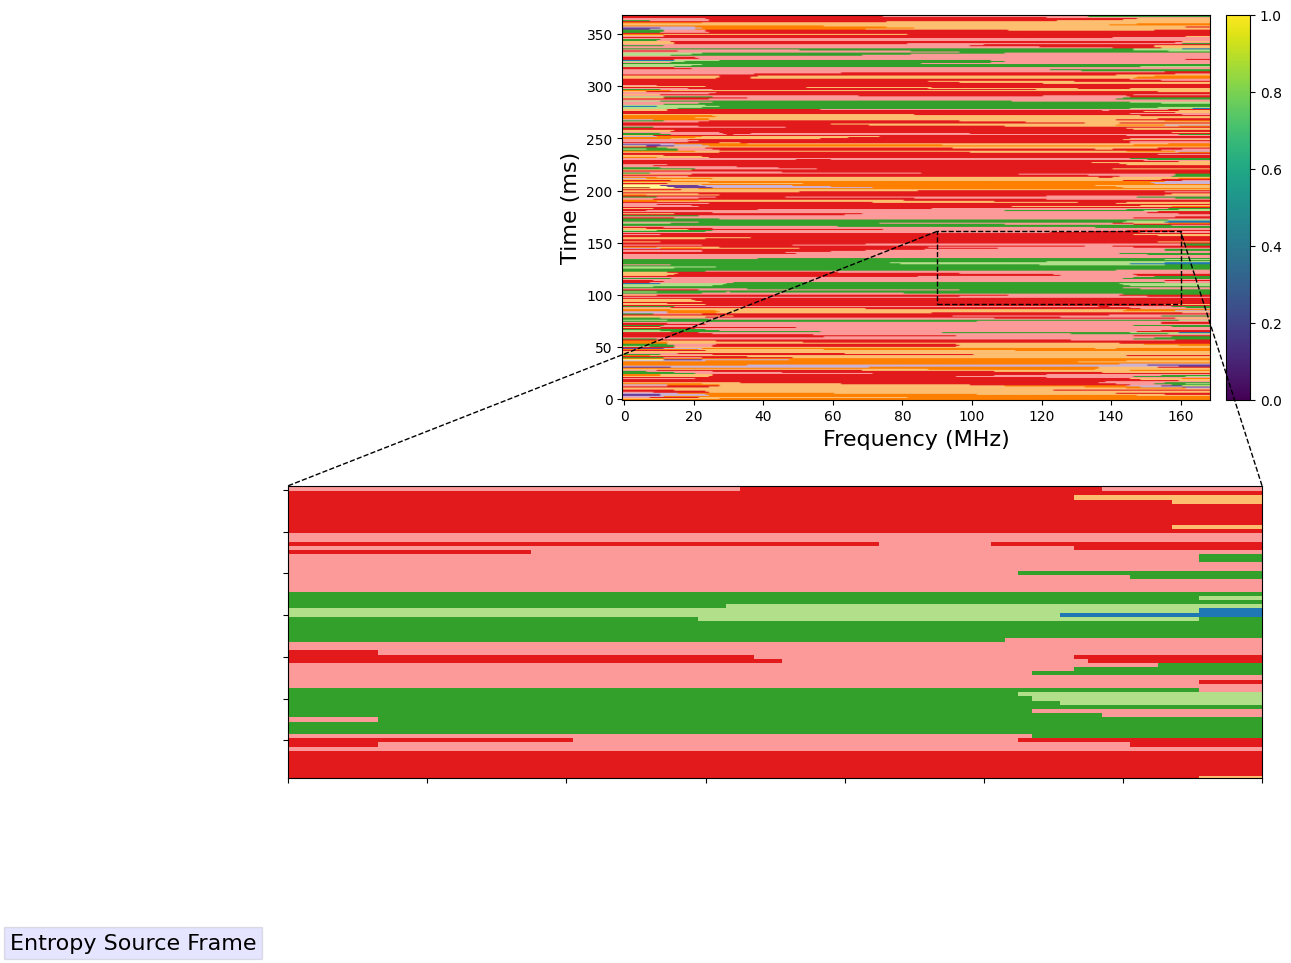

In [111]:
# np.random.seed(31)
sel_img = files[np.random.randint(0,len(files))]
    
input_img = plt.imread(sel_img)
print(input_img.shape)

# The x and y values from img.shape is flipped so in order to get correct frame sizes they are flipped here.
start_x = np.random.randint(input_img.shape[1] - FRAME_SIZE)
start_y = np.random.randint(input_img.shape[0] - FRAME_SIZE)

fig = plt.figure(figsize=(8, 5), dpi=100)
ax = fig.add_subplot(111)
heatmap = plt.imshow(input_img,origin='lower')
plt.ylabel('Time (ms)', fontsize=16)
plt.xlabel('Frequency (MHz)', fontsize=16)
ax.set_aspect(0.30)
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.03,ax.get_position().height])
plt.colorbar(heatmap, cax=cax)
#plt.savefig(PROJECT_FOLDER + 'input_' + str(i) + '.pdf' ,bbox_inches='tight')

axins = zoomed_inset_axes(ax, 4, loc=4, bbox_to_anchor=(0.8,-1,.3,.3), bbox_transform=ax.transAxes)
axins.imshow(input_img)
axins.set_aspect(0.30)
axins.set_xlim(start_x, start_x + FRAME_SIZE)
axins.set_ylim(start_y, start_y + FRAME_SIZE)


plt.xticks(visible=False)
plt.yticks(visible=False)

mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="k", ls="--")
plt.draw()

plt.text(70,50, 'Entropy Source Frame',fontsize=16, bbox=dict(facecolor='blue', alpha=0.1))

plt.savefig("entropy_source.png",dpi=100,bbox_inches='tight')

plt.show()

In [16]:
# Used for finding a correct way to create enough number.
entropy_values = []
c_list = np.linspace(1, 250, num=250).astype(int)
k_list = np.linspace(1, 250, num=250).astype(int)

c_list = [FRAME_SIZE]
k_list = [FRAME_SIZE]


EXPERIMENT_SIZE = 1
NUM_OF_ELEMENTS = 512
SIZE = 2012

entropies = []
np.random.shuffle(c_list)
np.random.shuffle(k_list)
for c_k_idx in tqdm(range(len(c_list)), leave=False): # zip(c_list, k_list):
    c = c_list[c_k_idx]
    k = k_list[c_k_idx]
    sel_img_idx = np.random.randint(0,num_of_files)
    entropy_val = get_entropy_spectrum(c,k,sel_img_idx)
    entropies.append(entropy_val)

randomint_sec3 = []
print(randomint_sec3)
for c_k_idx in tqdm(range(len(c_list)), leave=False): # zip(c_list, k_list):
    np.random.SeedSequence(entropies[c_k_idx])
    for i in tqdm(range(SIZE)):
        
        tmp = np.random.randint(0, NUM_OF_ELEMENTS, 2048)
        randomint_sec3.extend(tmp)    

512 2012


[]


100%|██████████| 2012/2012 [00:00<00:00, 4422.03it/s]


In [20]:
# Used to create 8 text files with 9 bit random values. 
# These are the basis for the comparison of the two NIST test suites.

# FRAME_SIZE = 10
NUM_OF_ELEMENTS = 512
SIZE = 2012
entropy_values = []

for i in tqdm(range(1,9)):
    FRAME_SIZE = 10 * i
    c_list = np.linspace(1, 369, num=369).astype(int)
    k_list = np.linspace(1, 169, num=169).astype(int)
    c_list = [FRAME_SIZE]
    k_list = [FRAME_SIZE]

    entropies = []
    np.random.shuffle(c_list)
    np.random.shuffle(k_list)
    for c_k_idx in range(len(c_list)): # zip(c_list, k_list):
        c = c_list[c_k_idx]
        k = k_list[c_k_idx]
        sel_img_idx = np.random.randint(0,num_of_files)
        entropy_val = get_entropy_spectrum(c,k,sel_img_idx)
        entropies.append(entropy_val)

    randomint_sec3 = []
    for c_k_idx in range(len(c_list)): # zip(c_list, k_list):
        np.random.SeedSequence(entropies[c_k_idx])
        for i in range(SIZE):
            tmp = np.random.randint(0, NUM_OF_ELEMENTS, 2048)
            randomint_sec3.extend(tmp) 

    
    f = open(f'randomint_sec3.txt','w')
    for i in range(len(randomint_sec3)):
        f.write("{0:b}".format(randomint_sec3[i]).zfill(9) + '\n')
    f.close()
    os.rename('randomint_sec3.txt', f'randomint_sec3_{FRAME_SIZE}.txt')

100%|██████████| 8/8 [01:34<00:00, 11.79s/it]


In [21]:
# Implementation of https://github.com/InsaneMonster/NistRng
for i in tqdm(range(1,9)):
    FRAME_SIZE = 10 * i
    !python rand_testsuite.py "randomint_sec3_{FRAME_SIZE}.txt" > "fs{FRAME_SIZE}_res.txt"

100%|██████████| 8/8 [08:54<00:00, 66.85s/it]


In [27]:
# Implementation of https://github.com/InsaneMonster/NistRng
from nistrng import *

for i in tqdm(range(1,9)):
    FRAME_SIZE = 10 * i
    handle = open(f"randomint_sec3_{FRAME_SIZE}.txt")
    data_list = []

    for line in handle:
        data_list.append(line.strip().rstrip())

    binary_sequence: np.ndarray = pack_sequence(data_list)
    eligible_battery: dict = check_eligibility_all_battery(binary_sequence, SP800_22R1A_BATTERY)
    results = run_all_battery(binary_sequence, eligible_battery, False)
    print("Test results:")
    for result, elapsed_time in results:
        if result.passed:
            print("- PASSED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")
        else:
            print("- FAILED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")

 12%|█▎        | 1/8 [1:43:35<12:05:11, 6215.96s/it]

Test results:
- PASSED - score: 0.87 - Monobit - elapsed time: 3 ms
- PASSED - score: 0.837 - Frequency Within Block - elapsed time: 4 ms
- PASSED - score: 0.836 - Runs - elapsed time: 8663 ms
- PASSED - score: 0.46 - Longest Run Ones In A Block - elapsed time: 1347 ms
- PASSED - score: 0.414 - Binary Matrix Rank - elapsed time: 211869 ms
- FAILED - score: 0.0 - Discrete Fourier Transform - elapsed time: 23539 ms
- FAILED - score: 0.0 - Non Overlapping Template Matching - elapsed time: 115013 ms
- FAILED - score: 0.0 - Overlapping Template Matching - elapsed time: 3524 ms
- FAILED - score: 0.0 - Maurers Universal - elapsed time: 39067 ms
- FAILED - score: 0.0 - Linear Complexity - elapsed time: 2945523 ms
- FAILED - score: 0.0 - Serial - elapsed time: 1178680 ms
- FAILED - score: 0.0 - Approximate Entropy - elapsed time: 1537745 ms
- FAILED - score: 0.0 - Cumulative Sums - elapsed time: 35678 ms
- FAILED - score: 0.683 - Random Excursion - elapsed time: 112625 ms
- PASSED - score: 0.17

 25%|██▌       | 2/8 [3:27:51<10:23:54, 6239.09s/it]

Test results:
- PASSED - score: 0.028 - Monobit - elapsed time: 3 ms
- PASSED - score: 0.066 - Frequency Within Block - elapsed time: 3 ms
- PASSED - score: 0.942 - Runs - elapsed time: 9478 ms
- PASSED - score: 0.365 - Longest Run Ones In A Block - elapsed time: 1352 ms
- PASSED - score: 0.608 - Binary Matrix Rank - elapsed time: 203595 ms
- FAILED - score: 0.0 - Discrete Fourier Transform - elapsed time: 21941 ms
- FAILED - score: 0.0 - Non Overlapping Template Matching - elapsed time: 108437 ms
- FAILED - score: 0.0 - Overlapping Template Matching - elapsed time: 3183 ms
- FAILED - score: 0.0 - Maurers Universal - elapsed time: 37929 ms
- FAILED - score: 0.0 - Linear Complexity - elapsed time: 2836690 ms
- FAILED - score: 0.0 - Serial - elapsed time: 1324897 ms
- FAILED - score: 0.0 - Approximate Entropy - elapsed time: 1561648 ms
- FAILED - score: 0.0 - Cumulative Sums - elapsed time: 34184 ms
- FAILED - score: 0.683 - Random Excursion - elapsed time: 108922 ms
- PASSED - score: 0.

 38%|███▊      | 3/8 [5:19:17<8:56:56, 6443.26s/it] 

Test results:
- PASSED - score: 0.334 - Monobit - elapsed time: 3 ms
- PASSED - score: 0.061 - Frequency Within Block - elapsed time: 3 ms
- PASSED - score: 0.976 - Runs - elapsed time: 8106 ms
- PASSED - score: 0.39 - Longest Run Ones In A Block - elapsed time: 1250 ms
- PASSED - score: 0.747 - Binary Matrix Rank - elapsed time: 190043 ms
- FAILED - score: 0.0 - Discrete Fourier Transform - elapsed time: 19370 ms
- PASSED - score: 0.39 - Non Overlapping Template Matching - elapsed time: 120640 ms
- FAILED - score: 0.0 - Overlapping Template Matching - elapsed time: 3444 ms
- FAILED - score: 0.0 - Maurers Universal - elapsed time: 38461 ms
- FAILED - score: 0.0 - Linear Complexity - elapsed time: 3012021 ms
- FAILED - score: 0.0 - Serial - elapsed time: 1338530 ms
- FAILED - score: 0.0 - Approximate Entropy - elapsed time: 1786623 ms
- FAILED - score: 0.0 - Cumulative Sums - elapsed time: 39327 ms
- FAILED - score: 0.683 - Random Excursion - elapsed time: 125305 ms
- PASSED - score: 0.

 50%|█████     | 4/8 [6:55:05<6:51:15, 6168.95s/it]

Test results:
- PASSED - score: 0.387 - Monobit - elapsed time: 4 ms
- PASSED - score: 0.864 - Frequency Within Block - elapsed time: 4 ms
- PASSED - score: 0.759 - Runs - elapsed time: 10659 ms
- PASSED - score: 0.031 - Longest Run Ones In A Block - elapsed time: 1588 ms
- PASSED - score: 0.695 - Binary Matrix Rank - elapsed time: 243373 ms
- FAILED - score: 0.0 - Discrete Fourier Transform - elapsed time: 21864 ms
- PASSED - score: 0.394 - Non Overlapping Template Matching - elapsed time: 145964 ms
- FAILED - score: 0.0 - Overlapping Template Matching - elapsed time: 4134 ms
- FAILED - score: 0.0 - Maurers Universal - elapsed time: 43627 ms
- FAILED - score: 0.0 - Linear Complexity - elapsed time: 2759016 ms
- FAILED - score: 0.0 - Serial - elapsed time: 1139215 ms
- FAILED - score: 0.0 - Approximate Entropy - elapsed time: 1253454 ms
- FAILED - score: 0.0 - Cumulative Sums - elapsed time: 28805 ms
- FAILED - score: 0.683 - Random Excursion - elapsed time: 93408 ms
- PASSED - score: 

 62%|██████▎   | 5/8 [8:25:05<4:54:34, 5891.56s/it]

Test results:
- PASSED - score: 0.711 - Monobit - elapsed time: 3 ms
- PASSED - score: 0.401 - Frequency Within Block - elapsed time: 2 ms
- PASSED - score: 0.177 - Runs - elapsed time: 7409 ms
- PASSED - score: 0.359 - Longest Run Ones In A Block - elapsed time: 1157 ms
- PASSED - score: 0.929 - Binary Matrix Rank - elapsed time: 173846 ms
- FAILED - score: 0.0 - Discrete Fourier Transform - elapsed time: 16003 ms
- FAILED - score: 0.0 - Non Overlapping Template Matching - elapsed time: 107025 ms
- FAILED - score: 0.0 - Overlapping Template Matching - elapsed time: 3246 ms
- FAILED - score: 0.0 - Maurers Universal - elapsed time: 34414 ms
- FAILED - score: 0.0 - Linear Complexity - elapsed time: 2592462 ms
- FAILED - score: 0.002 - Serial - elapsed time: 1123966 ms
- FAILED - score: 0.0 - Approximate Entropy - elapsed time: 1219458 ms
- FAILED - score: 0.0 - Cumulative Sums - elapsed time: 26597 ms
- FAILED - score: 0.683 - Random Excursion - elapsed time: 91810 ms
- PASSED - score: 0

c:\Python310\lib\site-packages\nistrng\test.py:47: RuntimeWarning: Mean of empty slice
  return float(numpy.nanmean(self._score_list))
 75%|███████▌  | 6/8 [9:57:48<3:12:39, 5779.65s/it]

Test results:
- PASSED - score: 0.48 - Monobit - elapsed time: 18 ms
- PASSED - score: 0.638 - Frequency Within Block - elapsed time: 4 ms
- PASSED - score: 0.182 - Runs - elapsed time: 7361 ms
- PASSED - score: 0.369 - Longest Run Ones In A Block - elapsed time: 1150 ms
- PASSED - score: 0.449 - Binary Matrix Rank - elapsed time: 173878 ms
- FAILED - score: 0.0 - Discrete Fourier Transform - elapsed time: 16171 ms
- PASSED - score: 0.289 - Non Overlapping Template Matching - elapsed time: 95720 ms
- FAILED - score: 0.0 - Overlapping Template Matching - elapsed time: 3253 ms
- FAILED - score: 0.0 - Maurers Universal - elapsed time: 35709 ms
- FAILED - score: 0.0 - Linear Complexity - elapsed time: 2632378 ms
- FAILED - score: nan - Serial - elapsed time: 1182151 ms
- FAILED - score: 0.0 - Approximate Entropy - elapsed time: 1286171 ms
- FAILED - score: 0.0 - Cumulative Sums - elapsed time: 31512 ms
- FAILED - score: 0.63 - Random Excursion - elapsed time: 94651 ms
- FAILED - score: 0.0

 88%|████████▊ | 7/8 [11:26:57<1:33:58, 5638.89s/it]

Test results:
- PASSED - score: 0.992 - Monobit - elapsed time: 0 ms
- PASSED - score: 0.795 - Frequency Within Block - elapsed time: 18 ms
- PASSED - score: 0.723 - Runs - elapsed time: 7410 ms
- PASSED - score: 0.761 - Longest Run Ones In A Block - elapsed time: 1157 ms
- PASSED - score: 0.646 - Binary Matrix Rank - elapsed time: 173802 ms
- FAILED - score: 0.0 - Discrete Fourier Transform - elapsed time: 16206 ms
- FAILED - score: 0.0 - Non Overlapping Template Matching - elapsed time: 107234 ms
- FAILED - score: 0.0 - Overlapping Template Matching - elapsed time: 3242 ms
- FAILED - score: 0.0 - Maurers Universal - elapsed time: 34446 ms
- FAILED - score: 0.0 - Linear Complexity - elapsed time: 2574475 ms
- FAILED - score: 0.0 - Serial - elapsed time: 1094665 ms
- FAILED - score: 0.0 - Approximate Entropy - elapsed time: 1211686 ms
- FAILED - score: 0.0 - Cumulative Sums - elapsed time: 30003 ms
- FAILED - score: 0.683 - Random Excursion - elapsed time: 92540 ms
- PASSED - score: 0.

100%|██████████| 8/8 [12:55:22<00:00, 5815.30s/it]  

Test results:
- PASSED - score: 0.205 - Monobit - elapsed time: 0 ms
- PASSED - score: 0.515 - Frequency Within Block - elapsed time: 0 ms
- PASSED - score: 0.431 - Runs - elapsed time: 7549 ms
- PASSED - score: 0.389 - Longest Run Ones In A Block - elapsed time: 1297 ms
- PASSED - score: 0.749 - Binary Matrix Rank - elapsed time: 173989 ms
- FAILED - score: 0.0 - Discrete Fourier Transform - elapsed time: 15550 ms
- FAILED - score: 0.0 - Non Overlapping Template Matching - elapsed time: 104009 ms
- FAILED - score: 0.0 - Overlapping Template Matching - elapsed time: 3109 ms
- FAILED - score: 0.0 - Maurers Universal - elapsed time: 33128 ms
- FAILED - score: 0.0 - Linear Complexity - elapsed time: 2553498 ms
- FAILED - score: 0.0 - Serial - elapsed time: 1104500 ms
- FAILED - score: 0.0 - Approximate Entropy - elapsed time: 1184631 ms
- FAILED - score: 0.0 - Cumulative Sums - elapsed time: 29466 ms
- FAILED - score: 0.63 - Random Excursion - elapsed time: 92296 ms
- FAILED - score: 0.0 

From comparison of https://github.com/InsaneMonster/NistRng and https://github.com/stevenang/randomness_testsuite  
The randomness testsuite takes 8 minutes and 54.8 seconds to run for 8 tests and the nistrng pip package takes 1 hour 43 minutes and 35 seconds for a single test. (12 Hours, 55 minutes for 8 tests.)
  
Running the loop to prepare all the data took 17 seconds.


In [6]:
import re
# Simple tests to analyze results from the NIST test suite. (To find if a frame size is better.)

results = [(0,0,0)]*16
avgResults = []
for i in tqdm(range(1,9)):
    FRAME_SIZE = 10 * i
    file = open(f'../fs{FRAME_SIZE}_res.txt')
    test_nr = 0
    total_average = 0
    random_excursion_test = False
    random_excursion_variant_test = False
    for line in file:
        if random_excursion_test:
            if re.search("\s+STATE", line) or re.search("\s+F", line):
                continue
            s_num = re.search("\s+\S+\s+\S+\s+", line).end()
            e_num = re.search("\s+T", line).start()
            ret_avg += float(line[s_num+1:e_num])
            if re.search("\'\+4", line):
                # Last line
                ret_avg = ret_avg / 8
                if results[test_nr][0] < ret_avg:
                    results[test_nr] = (test_nr+1, ret_avg, FRAME_SIZE)
                total_average += ret_avg
                test_nr += 1
                random_excursion_test = False
            continue
        if random_excursion_variant_test:
            if re.search("\s+STATE", line) or re.search("\s+F", line):
                continue
            s_num = re.search("\s+\S+\s+\S+\s+", line).end()
            e_num = re.search("\s+T", line).start()
            revt_avg += float(line[s_num:e_num])
            if re.search("\'\+9.0", line):
                # Last line
                revt_avg = revt_avg / 18
                if results[test_nr][1] < revt_avg:
                    results[test_nr] = (test_nr+1, revt_avg, FRAME_SIZE)
                total_average += revt_avg
                test_nr += 1
                random_excursion_variant_test = False
            continue
        if re.search("^2.11", line):
            startsearch = re.search(":", line).start()
            if startsearch:
                line = line[startsearch:]
                s_num1 = re.search("\(\(",line).end()
                e_num1 = re.search(",", line).start()
                s_num2 = re.search("\(", line).end()
                e_num2 = re.search(",", line).end()
                num1 = float(line[s_num1:e_num1])
                num2 = float(line[s_num2+1:e_num2-1])
                avg = (num1 + num2) / 2
                if results[test_nr][1] < avg:
                    results[test_nr] = (test_nr+1, avg, FRAME_SIZE)
                test_nr += 1
                total_average += avg
        if re.search("^2.14", line):
            random_excursion_test = True
            ret_avg = 0
            continue
        if re.search("^2.15", line):
            random_excursion_variant_test = True
            revt_avg = 0
            continue
        if re.search("^2.+", line):
            startsearch = re.search(":", line).start()
            if startsearch:
                line = line[startsearch:]
                s_num = re.search("\(",line).start()
                e_num = re.search(",", line).start()
                number = float(line[s_num+1:e_num])
                if results[test_nr][1] < number:
                    results[test_nr] = (test_nr+1, number, FRAME_SIZE)
                test_nr += 1
                total_average += number
    avgResults.append((total_average / 16, FRAME_SIZE))
    file.close()
print(f"All top results and their corresponding Frame size:\n\n {results} \n\n "
       f"All total average results per Frame size: \n\n {avgResults}")



100%|██████████| 8/8 [00:00<00:00, 1000.10it/s]

All top results and their corresponding Frame size:

 [(1, 0.9776621511479011, 60), (2, 0.9500362441063992, 10), (3, 0.9344798954677771, 10), (4, 0.9906838664659319, 70), (5, 0.8306742696194289, 30), (6, 0.8185458083820434, 60), (7, 0.9647154663121017, 50), (8, 0.9894308001736392, 70), (9, 0.998112275608949, 40), (10, 0.8941504484483742, 80), (11, 0.9188976859657026, 60), (12, 0.8065421182826283, 40), (13, 0.9046021292930511, 20), (14, 0.7270834962296464, 20), (15, 0.46253891511628104, 10), (16, 0.8448620042036202, 50)] 

 All total average results per Frame size: 

 [(0.46979530364237554, 10), (0.47088824526339046, 20), (0.4327173916668881, 30), (0.5153961209622034, 40), (0.5985104837342509, 50), (0.6404969122334114, 60), (0.44784836756023005, 70), (0.47778546017011947, 80)]


Frame Size = 70 contains 6 False (Random Excursion Variant Test),  all others contain no False tests (Unpassed).
